In [8]:
from dataset import AIArtBenchDataset
from torch.utils.data import DataLoader
import torch
import timm
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.transforms import Resize, Normalize, Compose, ToTensor, Lambda
from torchvision.models import resnet50
import torch.nn as nn

root = '/home/amk/data/Real_AI_SD_LD_Dataset'

train_data = AIArtBenchDataset(
    root=root,
    for_training=False,
    transforms=None,
    target_transforms=None
)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    Lambda(lambda x: x.float()),  # Convert images to float tensors
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=mean, std=std)
])

reverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
])

/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, '1')

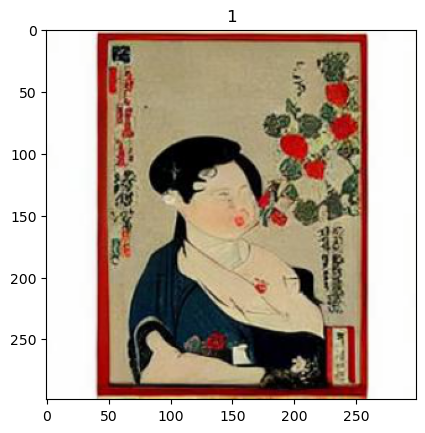

In [12]:
img, label = train_data[2000]
img = transform(img).reshape((1, 3, 299, 299))
img_grad = torch.tensor(img.numpy(), requires_grad=True)

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.title(label)

In [13]:
model = models.inception_v3(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load('inception_model_new.pth'))

model2 = timm.create_model('efficientnet_b4', pretrained=False, num_classes=3) #pretrained on imagenet
model2.load_state_dict(torch.load('efficient_model.pth'))

class MyResNet(nn.Module):
    def __init__(self, num_classes, is_pretrained=False):
        super(MyResNet, self).__init__()

        # Instantiate a pretrained/randomly-initialized resnet model
        self.resnet_model = resnet50(pretrained=is_pretrained)

        # Modify last layer to map to 3 output classes
        in_features = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet_model(x)

model3 = MyResNet(num_classes=3, is_pretrained=False)
model3.load_state_dict(torch.load('resnet_model.pth'))

/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/amk/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

Start losses (Inception)): tensor([[-9.6623,  3.0907, -1.6194]], grad_fn=<AddmmBackward0>)
Start losses (EfficientNet)): tensor([[-65.9777, 214.1525, -13.0303]], grad_fn=<AddmmBackward0>)
Start losses (Resnet)): tensor([[-8.8427,  5.8806, -3.7311]], grad_fn=<AddmmBackward0>)
epoch 1: loss = 4.719132900238037
epoch 2: loss = 17.031742095947266
epoch 3: loss = 34.03172302246094
epoch 4: loss = 30.801000595092773
epoch 5: loss = 21.306854248046875
epoch 6: loss = 8.949376106262207
epoch 7: loss = 7.441016674041748
epoch 8: loss = 8.067025184631348
epoch 9: loss = 6.18127965927124
epoch 10: loss = 5.432007789611816
epoch 11: loss = 3.393343448638916
epoch 12: loss = 0.260345458984375
epoch 13: loss = 0.06742158532142639
epoch 14: loss = 0.03398666903376579
epoch 15: loss = 0.015199316665530205
epoch 16: loss = 0.04027603939175606
epoch 17: loss = 0.28090664744377136
epoch 18: loss = 0.6951373219490051
epoch 19: loss = 0.3005976676940918
epoch 20: loss = 0.07355694472789764
epoch 21: loss =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Start losses (Resnet)): tensor([[-6.6223,  6.7706, -5.9311]], grad_fn=<AddmmBackward0>)


Text(0.5, 1.0, 'Adversarial Attack: Inception V3')

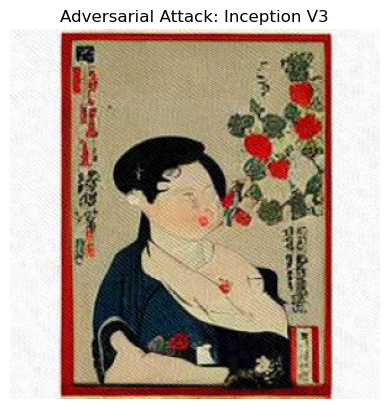

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([img_grad], lr=10)

target_class_label = 2
target = torch.Tensor([target_class_label]).long()

model.eval()
model2.eval()
model3.eval()

print(f'Start losses (Inception)): {model(img_grad)}')
print(f'Start losses (EfficientNet)): {model2(img_grad)}')
print(f'Start losses (Resnet)): {model3(img_grad)}')

num_epochs = 50
for epoch in range(1, num_epochs+1):
    optimizer.zero_grad()
    output = model(img_grad)
    loss = criterion(output, target)
    loss.backward()

    optimizer.step()

    print(f'epoch {epoch}: loss = {loss}')

print(f'Start losses (Inception)): {model(img_grad)}')
print(f'Start losses (EfficientNet)): {model2(img_grad)}')
print(f'Start losses (Resnet)): {model3(img_grad)}')

plt.imshow(reverse_transform(img_grad).to(torch.int16).detach().reshape((3, 299, 299)).permute(1, 2, 0))
plt.axis('off')
plt.title('Adversarial Attack: Inception V3')